In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from itertools import product
import matplotlib.pyplot as plt
import matplotlib.dates as dates

In [4]:
covid_tracking_data_folder = '../data/covid_tracking/' # path to data from the covid tracking project

florida_df = pd.read_csv(os.path.join(covid_tracking_data_folder, 'florida-history.csv'), parse_dates=['date'])
national_df = pd.read_csv(os.path.join(covid_tracking_data_folder, 'national-history.csv'), parse_dates=['date'])

In [5]:
print(florida_df.columns)
print(national_df.columns)

Index(['date', 'state', 'dataQualityGrade', 'death', 'deathConfirmed',
       'deathIncrease', 'deathProbable', 'hospitalized',
       'hospitalizedCumulative', 'hospitalizedCurrently',
       'hospitalizedIncrease', 'inIcuCumulative', 'inIcuCurrently', 'negative',
       'negativeIncrease', 'negativeTestsAntibody',
       'negativeTestsPeopleAntibody', 'negativeTestsViral',
       'onVentilatorCumulative', 'onVentilatorCurrently', 'positive',
       'positiveCasesViral', 'positiveIncrease', 'positiveScore',
       'positiveTestsAntibody', 'positiveTestsAntigen',
       'positiveTestsPeopleAntibody', 'positiveTestsPeopleAntigen',
       'positiveTestsViral', 'recovered', 'totalTestEncountersViral',
       'totalTestEncountersViralIncrease', 'totalTestResults',
       'totalTestResultsIncrease', 'totalTestsAntibody', 'totalTestsAntigen',
       'totalTestsPeopleAntibody', 'totalTestsPeopleAntigen',
       'totalTestsPeopleViral', 'totalTestsPeopleViralIncrease',
       'totalTestsViral'

DatetimeIndex(['2020-12-07', '2020-12-06', '2020-12-05', '2020-12-04',
               '2020-12-03', '2020-12-02', '2020-12-01', '2020-11-30',
               '2020-11-29', '2020-11-28',
               ...
               '2020-02-07', '2020-02-06', '2020-02-05', '2020-02-04',
               '2020-02-03', '2020-02-02', '2020-02-01', '2020-01-31',
               '2020-01-30', '2020-01-29'],
              dtype='datetime64[ns]', name='date', length=314, freq=None)
DatetimeIndex(['2020-12-07', '2020-12-06', '2020-12-05', '2020-12-04',
               '2020-12-03', '2020-12-02', '2020-12-01', '2020-11-30',
               '2020-11-29', '2020-11-28',
               ...
               '2020-02-07', '2020-02-06', '2020-02-05', '2020-02-04',
               '2020-02-03', '2020-02-02', '2020-02-01', '2020-01-31',
               '2020-01-30', '2020-01-29'],
              dtype='datetime64[ns]', name='date', length=314, freq=None)
DatetimeIndex(['2020-12-07', '2020-12-06', '2020-12-05', '2020-12-04',
 

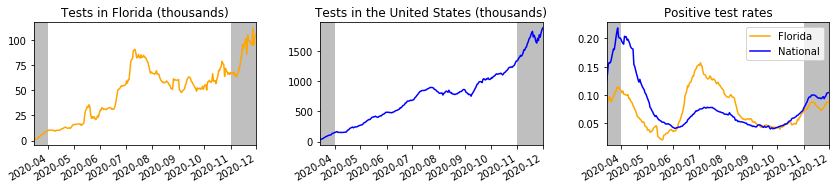

In [13]:
def get_rolling_df(df, time='RESULT', freq=7, var='covid'):
    df = df.set_index(time)
    print(df.index)
    freqd = '{}D'.format(freq)
   # print('before_rolling', df[(df.index=='2020-03-08')][['Age_group', 'Died']])

    df = df.rolling(freqd, min_periods=0)[var].sum().reset_index()
    df = df.set_index(time)

    df = df.groupby(time)[var].max().reset_index()
    df = df.set_index(time)

    df[var].fillna(0, inplace=True)
    df[var] = df[var]/7
    df.sort_values(by=time,inplace=True)
    
    return df

min_date = '2020-03-15'
study_min = '2020-04-01'
study_max = '2020-11-01'
max_date = '2020-12-01'

def get_test_rates(df):
    pos_roll = get_rolling_df(df.copy(), time='date', freq=7, var='positiveIncrease')
    tot_roll = get_rolling_df(df.copy(), time='date', freq=7, var='totalTestResultsIncrease')

    pos_roll = pos_roll[(pos_roll.index >= min_date) & (pos_roll.index <= max_date)]
    tot_roll = tot_roll[(tot_roll.index >= min_date) & (tot_roll.index <= max_date)]

    pos_rate = pos_roll['positiveIncrease'] / tot_roll['totalTestResultsIncrease']
    return pos_rate, pos_roll, tot_roll
    
fig, ax = plt.subplots(1, 3, figsize=(12, 2.6))
ax[0].set_title('Tests in Florida (thousands)')
ax[1].set_title('Tests in the United States (thousands)')
ax[2].set_title('Positive test rates')

# florida
fl_pos_rate, fl_pos_roll, fl_tot_roll = get_test_rates(florida_df)
ax[2].plot(fl_pos_rate, label='Florida', color='orange')
ax[0].plot(fl_tot_roll / 1000, color='orange')

# national
nt_pos_rate, nt_pos_roll, nt_tot_roll = get_test_rates(national_df)
ax[2].plot(nt_pos_rate, label='National', color='blue')
ax[1].plot(nt_tot_roll / 1000, color='blue')

ax[2].legend(loc='upper right')

ax[0].axvspan(pd.Timestamp(study_max), pd.Timestamp(max_date), color='grey', alpha=0.5, lw=0)
ax[1].axvspan(pd.Timestamp(study_max), pd.Timestamp(max_date), color='grey', alpha=0.5, lw=0)
ax[2].axvspan(pd.Timestamp(study_max), pd.Timestamp(max_date), color='grey', alpha=0.5, lw=0)

ax[0].axvspan(pd.Timestamp(min_date), pd.Timestamp(study_min), color='grey', alpha=0.5, lw=0)
ax[1].axvspan(pd.Timestamp(min_date), pd.Timestamp(study_min), color='grey', alpha=0.5, lw=0)
ax[2].axvspan(pd.Timestamp(min_date), pd.Timestamp(study_min), color='grey', alpha=0.5, lw=0)

ax[0].set_xlim(pd.Timestamp(min_date), pd.Timestamp(max_date))
ax[1].set_xlim(pd.Timestamp(min_date), pd.Timestamp(max_date))
ax[2].set_xlim(pd.Timestamp(min_date), pd.Timestamp(max_date))

date_fmt = '20%y-%m'
formatter = dates.DateFormatter(date_fmt)
ax[0].xaxis.set_major_locator(dates.MonthLocator())
ax[0].xaxis.set_major_formatter(formatter)
ax[1].xaxis.set_major_locator(dates.MonthLocator())
ax[1].xaxis.set_major_formatter(formatter)
ax[2].xaxis.set_major_locator(dates.MonthLocator())
ax[2].xaxis.set_major_formatter(formatter)

plt.tight_layout()
plt.gcf().autofmt_xdate()

fig.savefig('img/results/pos_test_rates.pdf')